In [1]:
%%capture
# download test data
!wget https://github.com/oscarkarnalim/sourcecodeplagiarismdataset/raw/master/IR-Plag-Dataset.zip
!unzip /content/IR-Plag-Dataset.zip

# set up ANTLR parser with Java grammar
!pip install antlr4-tools
!pip install antlr4-python3-runtime
!wget https://raw.githubusercontent.com/antlr/grammars-v4/master/java/java/JavaLexer.g4
!antlr4 -Dlanguage=Python3 /content/JavaLexer.g4

In [3]:
from antlr4 import FileStream, CommonTokenStream
from JavaLexer import JavaLexer
from functools import lru_cache
from typing import List, Tuple, Set, Callable
import math
import glob
import pandas as pd
from tqdm import tqdm
from itertools import product
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)

In [4]:
# since reading and tokenizing files takes so long, add an lru cache
@lru_cache(maxsize=250)
def tokenize_java(src):
    input_stream = FileStream(src)
    lexer = JavaLexer(input_stream)
    token_stream = CommonTokenStream(lexer)
    token_stream.fill()
    tokens = [token for token in token_stream.tokens][:-1]
    tokens = [e.text for e in tokens if e.type not in [125, 126, 127, 78, 79]]
    return tokens

In [5]:
def hash_tokens(tokens: List[str], k: int) -> List[int]:
    ngrams = []
    for i in range(0, len(tokens) - k):
        ngrams.append(tuple(tokens[i : i + k]))
    return [hash(ngram) for ngram in ngrams]


def winnow_hashes(hashes: List[int], w: int) -> List[int]:
    fingerprint = []
    for i in range(0, len(hashes) - w):
        val = min(hashes[i : i + w])
        if len(fingerprint) == 0 or fingerprint[-1] != val:
            fingerprint.append(val)
    return fingerprint


def fingerprint_java(source: str, k: int, w: int) -> List[int]:
    return winnow_hashes(hash_tokens(tokenize_java(source), k), w)

In [29]:
ComparisonFunctionType = Callable[[Set[int], Set[int]], float]


def jaccard_similarity(set_a: set, set_b: set) -> float:
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union


def sorensen_dice_coefficient(set_a: set, set_b: set) -> float:
    intersection_size = len(set_a.intersection(set_b))
    total_size = len(set_a) + len(set_b)

    if total_size == 0:
        return 1.0  # Both sets are empty, consider them as identical

    return 2.0 * intersection_size / total_size


def log_dice(set_a: set, set_b: set) -> float:
    return math.log(sorensen_dice_coefficient(set_a, set_b))


def tversky_index(set_a: set, set_b: set, alpha=0.5, beta=0.5) -> float:
    intersection_size = len(set_a.intersection(set_b))
    false_positive = alpha * len(set_a - set_b)
    false_negative = beta * len(set_b - set_a)

    denominator = intersection_size + false_positive + false_negative

    if denominator == 0:
        return 0.0

    tversky = intersection_size / denominator
    return tversky

In [7]:
def compare_fingerprints(
    fingerprint1: List[int],
    fingerprint2: List[int],
    comparison_function: ComparisonFunctionType,
    threshold: float,
) -> bool:

    return comparison_function(set(fingerprint1), set(fingerprint2)) > threshold

In [8]:
def test_java(
    k: int,
    w: int,
    threshold: float,
    comparison_function: ComparisonFunctionType,
    test_dataset: int,
):
    original_dir = (
        f"/content/IR-Plag-Dataset/case-0{test_dataset}/original/T{test_dataset}.java"
    )
    plag_dir = f"/content/IR-Plag-Dataset/case-0{test_dataset}/plagiarized"
    legit_dir = f"/content/IR-Plag-Dataset/case-0{test_dataset}/non-plagiarized"

    predicted_labels = []
    true_labels = []

    # original source
    original_fingerprint = fingerprint_java(original_dir, k, w)

    # plagiarized source
    for L in range(1, 7):
        for f in glob.glob(plag_dir + f"/L{L}/*/*.java"):
            true_labels.append(True)
            isPlag = compare_fingerprints(
                original_fingerprint,
                fingerprint_java(f, k, w),
                comparison_function,
                threshold,
            )
            predicted_labels.append(isPlag)

    # legit source
    for f in glob.glob(legit_dir + "/*/*.java"):
        true_labels.append(False)
        isPlag = compare_fingerprints(
            original_fingerprint,
            fingerprint_java(f, k, w),
            comparison_function,
            threshold,
        )
        predicted_labels.append(isPlag)

    res = {
        "k": k,
        "w": w,
        "threshold": threshold,
        "comparison_function": comparison_function.__name__,
        "test_dataset": test_dataset,
        "overall_accuracy": accuracy_score(true_labels, predicted_labels),
    }

    return {"true": true_labels, "predicted": predicted_labels, "res": res}

In [20]:
def grid_search():
    df = pd.DataFrame()

    # Define the range of hyperparameters
    k_range = range(1, 6)
    w_range = range(1, 6)
    threshold_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    test_datasets = [i for i in range(1, 8)]
    comparison_functions = [
        jaccard_similarity,
        sorensen_dice_coefficient,
        log_dice,
        tversky_index,
    ]

    # Use itertools.product to generate all combinations of hyperparameters
    hyperparameter_combinations = product(
        k_range, w_range, threshold_range, test_datasets, comparison_functions
    )

    # Wrap the iterator with tqdm for a progress bar
    hyperparameter_combinations = tqdm(
        hyperparameter_combinations,
        total=len(k_range)
        * len(w_range)
        * len(threshold_range)
        * len(test_datasets)
        * len(comparison_functions),
        desc="Grid Search",
    )

    for k, w, threshold, test_datasets, comparison_function in hyperparameter_combinations:
        res = test_java(k, w, threshold, comparison_function, test_datasets)["res"]
        entry = pd.DataFrame.from_dict([res])
        df = pd.concat([df, entry], ignore_index=True)

    return df


df = grid_search()
df

Grid Search: 100%|██████████| 6300/6300 [08:34<00:00, 12.23it/s]


,k,w,threshold,comparison_function,t,overall_accuracy
0,1,1,0.1,jaccard_similarity,1,0.727273
1,1,1,0.1,sorensen_dice_coefficient,1,0.727273
2,1,1,0.1,log_dice,1,0.272727
3,1,1,0.1,tversky_index,1,0.727273
4,1,1,0.1,jaccard_similarity,2,0.782609
...,...,...,...,...,...,...
6295,5,5,0.9,tversky_index,6,0.348485
6296,5,5,0.9,jaccard_similarity,7,0.257576
6297,5,5,0.9,sorensen_dice_coefficient,7,0.257576
6298,5,5,0.9,log_dice,7,0.227273


In [21]:
df.groupby("comparison_function")["overall_accuracy"].mean()

comparison_function
jaccard_similarity           0.528190
log_dice                     0.229503
sorensen_dice_coefficient    0.599677
tversky_index                0.599677
Name: overall_accuracy, dtype: float64

In [23]:
df.groupby(["comparison_function", "t"])["overall_accuracy"].mean()

comparison_function        t
jaccard_similarity         1    0.581899
                           2    0.485346
                           3    0.490547
                           4    0.525475
                           5    0.558170
                           6    0.525387
                           7    0.530505
log_dice                   1    0.272727
                           2    0.217391
                           3    0.223881
                           4    0.217391
                           5    0.220588
                           6    0.227273
                           7    0.227273
sorensen_dice_coefficient  1    0.632323
                           2    0.556393
                           3    0.563847
                           4    0.612818
                           5    0.632222
                           6    0.596498
                           7    0.603636
tversky_index              1    0.632323
                           2    0.556393
                           3

Accuracy: 0.9710144927536232
f1: 0.9811320754716981


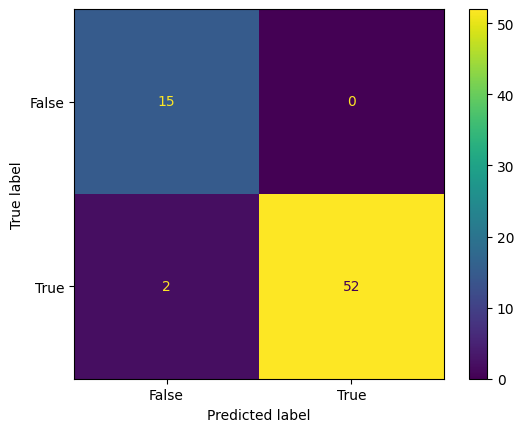

In [28]:
# @title Test plagiarim detection
k = 5  # @param {type:"number"}
w = 4  # @param {type:"number"}
threshold = 0.3  # @param {type:"slider", min:0, max:1, step:0.1}
comparison_algorithm = "sorensen_dice_coefficient"  # @param ['jaccard_similarity', 'sorensen_dice_coefficient', 'log_dice', 'tversky_index']
test_dataset = "4"  # @param ['1', '2', '3', '4', '5', '6', '7']

res = test_java(k, w, threshold, locals()[comparison_algorithm], int(test_dataset))
ConfusionMatrixDisplay.from_predictions(res["true"], res["predicted"])
print(f'Accuracy: {accuracy_score(res["true"], res["predicted"])}')
print(f'f1: {f1_score(res["true"], res["predicted"])}')